**Course**: [_Systèmes dynamiques en biologie_](https://moodle.epfl.ch/course/info.php?id=14291) (BIO-341)

**Professor**: _Felix Naef_

SSV, BA5, 2022

# Series 11

In [1]:
#import important libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from scipy.integrate import odeint
set_matplotlib_formats('png', 'pdf')
matplotlib.rc('image', cmap='RdBu')
import matplotlib.animation as animation
from random import random
from time import time

/var/folders/0n/3fx_dk3974l5gcd61jbvt2200000gr/T/ipykernel_9889/1913339053.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


## Organization of the circadian oscillator network in the brain
  
In mammals, circadian timing is regulated by the master clock, which is composed of about 20000 neurons located in the suprachiasmatic nucleus (SCN) in the hypothalamus. The neurons in the SCN are synchronized with each other, in part, by neurotransmitters that are secreted by the neurons. Here, we are interested in how different connectivities affect collective synchronization and oscillatory behavior. For simplicity, we will consider a theoretical model of the SCN in which coupled oscillators are arranged in a 2-dimensional space (grid). We can construct a symmetric adjacency matrix (coupling matrix) $\mathbf{A}$ where $\mathbf{A_{ij}}=\mathbf{A_{ji}}$ specifies the coupling between oscillator $i$ and oscillator $j$. Here, we consider the simplest case where $\mathbf{A_{ij}}$ is either 0 or 1. This coupling is modulated by a strength $K$. 

For each neuron $i$, $\dot{\theta}_i = f_i + K  \sum_{j=1}^{N}\mathbf{A_{ij}} \sin (\theta_j-\theta_i)$

**Definition**
A useful quantity called the 'order parameter' $R$ is defined as $R = \frac{1}{N}\sum_{j=1}^{N}e^{i\theta_j}$  where $e^{i\theta_j}$ are vectors on the unit circle.
  

We provide you with two functions: 
- heatmap: plot a $n \times n$ grid ($N := n^2$ being the number of neurons), which represents the SCN. Each cell shows the value contained in the matrix _datagrid_. The values are plotted from bottom left to top right, row by row.
- value_to_size: create the grid on which the oscillators are. This function is called by heatmap. 

In [2]:
#create a grid on which the oscillators are 

def value_to_size(val, size_min, size_max, size_scale):
    val = abs(val) #to handle negative  numbers
    val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
    return val_position * size_scale
    
def heatmap(datagrid, marker, ax):
    x = list(range(datagrid.shape[1]))
    y = list(range(datagrid.shape[0]))
    
    size_min, size_max = 0, 1
    size_scale = 500

    #dot the scatter + 2 extra invisible points to normalize colors
    scat = ax.scatter(
        x=x*len(y) + [-100,-100] ,
        y=[v for v in y for p in x]+ [-100,-100],
        marker=marker,
        s=[value_to_size(v, size_min, size_max, size_scale ) for v in datagrid.flatten()]+ [1,1],
        c = [v for v in datagrid.flatten()]+[-1,1],
        cmap = 'RdBu',
    )
    
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.set_yticks(y)
    ax.set_yticklabels(y)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max(x) + 0.5])
    ax.set_ylim([-0.5, max(y) + 0.5])
    ax.set_facecolor('#F1F1F1')

Below is an example of how to use the functions to plot the phase of each neuron in each cell of the grid: 

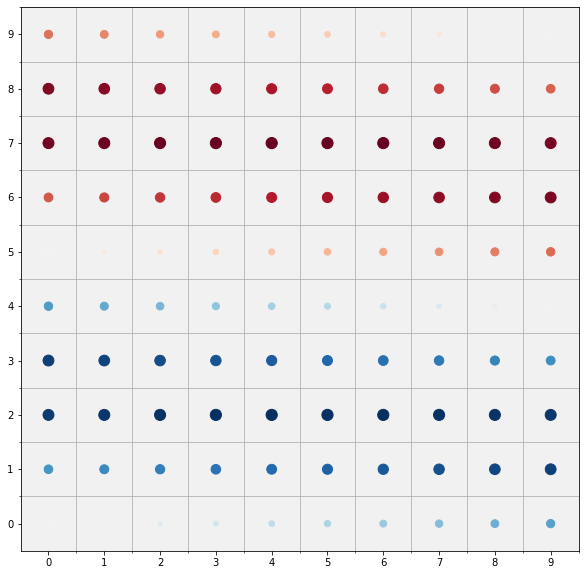

In [3]:
#create 100 cells (10*10 grid)
N = 100
n = int(N**0.5)

#create a vector of increasing phases to check the order of the oscillators on the plotted grid
l_x0 = np.linspace(0,2*np.pi, N)

#reshape l_x0 to match the grid
X = np.reshape(l_x0, (n,n))

#plot the oscillators
datagrid = np.sin(X)
fig, ax = plt.subplots(figsize=(X.shape[0],X.shape[1]))
heatmap(datagrid, marker='.',ax = ax)
plt.show()

#### Question 1: 
Assume that every neuron is connected to its nearest neighbours in the grid: for example, a neuron in position $(i,j)$ will be connected to the neurons at $(i-1,j)$, $(i+1,j)$, $(i, j-1)$ and $(i, j+1)$. Assume also that the neuron is connected to its second nearest neighbours: $(i-1,j-1)$, $(i-1,j+1)$, $(i+1,j-1)$, $(i+1,j+1)$.

Visualize the circadian oscillations of neurons at different times using the provided function heatmap and using subplots. Compute the value of the order parameter $R$ for each time point and add it to the plot.

**Hint** : 
Initialize the parameters of a population of $N$ neurons ($N$~100--1000 cells) with varying intrinsic periods of about 24 hours. For instance, you can modify the period of a neuron $i$ by drawing $f_i$ from a normal distribution with $\mu =2\pi/24$ and $\sigma$ equal to $5\%$ of the mean (you may have to play with $\sigma$ to obtain synchronization). Assign coordinates to each cell in a 2D grid, e.g. with x and y coordinates in a rectangle (the real SCN has an ‘egg’ shape). Choose $K = 0.03$. 

In [4]:
def model(l_theta, t, l_f, K, A): # l_theta: list of initial phase of the N neurons, t = time (needed for odeint), 
    # l_f: intrinsic frequencies of the neurons, K: coupling strength, A: interaction matrix
    
    #compute interaction matrix
    INT = np.zeros((len(l_theta), len(l_theta)))
    for i, theta_i in enumerate(l_theta):
        for j, theta_j in enumerate(l_theta):
            INT[i,j] = np.sin(theta_j-theta_i)
            
    #multiply by the interaction matrix
    NINT = np.multiply(INT, A) 
    
    
    #simulate the system with the new set of interaction
    return np.array([f+K*np.sum(NINT[i,:]) for i, (theta, f) in enumerate(zip(l_theta, l_f))])

In [5]:
# Defining some interaction matrices

def A_alltoall(N, p=1):
    
    A = np.zeros((N,N))
    for i in range(A.shape[0]):
        for j in range(i+1, A.shape[1]):
            A[i,j] = 1 if random()<p else 0
            A[j,i] = A[i,j] 
    return A


def A_NN(N):
    # Nearest Neighbours
    
    A = np.zeros((N,N))
    n = int(np.sqrt(N))
    neuron_index = np.arange(N)
    NI = np.reshape(neuron_index,(n,n))
    
    for i in range(n): # row number
        for j in range(n): # column number
            
            if i < n-1: A[NI[i,j]][NI[i+1,j]] = 1 
            
            if i > 0: A[NI[i,j]][NI[i-1,j]] = 1
            
            if j < n-1: A[NI[i,j]][NI[i,j+1]] = 1
            
            if j > 0: A[NI[i,j]][NI[i,j-1]] = 1
            
            A[NI[i,j]][NI[i,j]] = 1
            
    return A


def A_2NN(N):
    # First and second Nearest Neighbours
    
    A = A_NN(N)
    n = int(np.sqrt(N))
    neuron_index = np.arange(N)
    NI = np.reshape(neuron_index,(n,n))
    
    for i in range(n): # row number
        for j in range(n): # column number
            
            # second nearest neightbours
            if i < n-1 and j < n-1: A[NI[i,j]][NI[i+1,j+1]] = 1
            
            if i < n-1 and j > 0: A[NI[i,j]][NI[i+1,j-1]] = 1
            if i > 0 and j < n-1: A[NI[i,j]][NI[i-1,j+1]] = 1
            
            if i > 0 and j > 0: A[NI[i,j]][NI[i-1,j-1]] = 1
            
            A[NI[i,j]][NI[i,j]] = 1
                
    return A

In [6]:
def order(l_angles):
    return np.mean([np.exp(1j*theta) for theta in l_angles])

In [7]:
#create a vector of intrinsic frequencies
mu = 2*np.pi/24
sigma = 0.1*mu
l_f = np.random.randn(N)*sigma+mu

#define time domain
dt = 0.25 # fixed
nsteps = 1000
T = dt * nsteps

tspan = np.linspace(0,T,nsteps)

#define coupling strength
K = 0.03


#define interaction matrix
A = A_2NN(N)

# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(A,cmap='Greys')
# ax.set_title("Interaction map")

#simulate cells
X = odeint(model, l_x0, tspan, args=(l_f, K, A))

#reshape X to match the interaction grid
X = np.reshape(X, (X.shape[0], n, n))

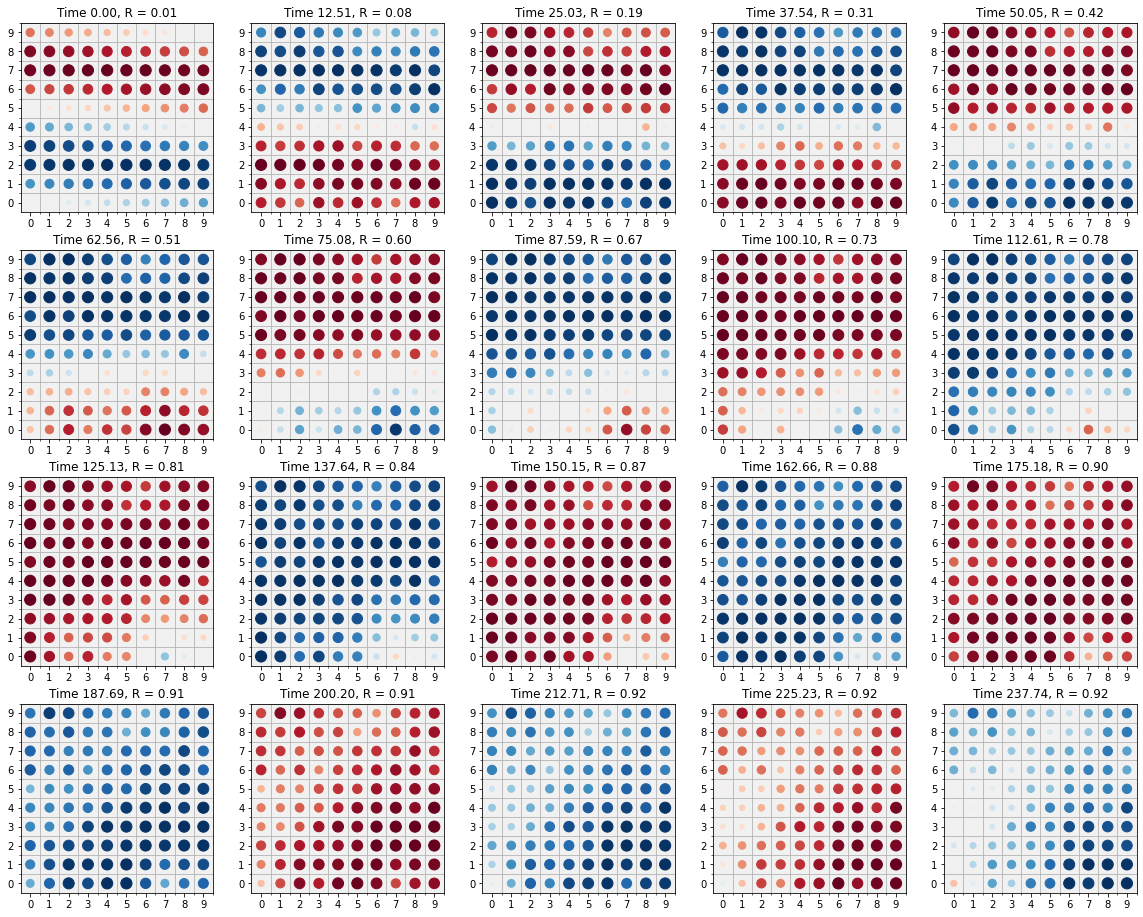

In [8]:
fig, axs = plt.subplots(4,5,figsize=(20,16))
axs = axs.flatten()

i_show = np.arange(0,nsteps,int(nsteps/20))

for ax, i in zip(axs, i_show):
    datagrid = np.sin(X[i,:])
    heatmap(datagrid, marker='.',ax=ax)
    ax.set_title("Time {0:.2f}, R = {1:.2f}".format(tspan[i], abs(order(X[i,:]))))

plt.show()

**Question 2**

Do the same plots as for Question 1 but for an all-to-all interaction matrix: $A_{ij}=1$ for all $i,j$. Set $K=0.001$.

How does the convergence change with respect to the previous case?

In [9]:
#create a vector of intrinsic frequencies
mu = 2*np.pi/24
sigma = 0.1*mu
l_f = np.random.randn(N)*sigma+mu

#define time domain
dt = 0.25 # fixed
nsteps = 1000
T = dt * nsteps

tspan = np.linspace(0,T,nsteps)

#define coupling strength
K = 0.001#


#define interaction matrix
A = A_alltoall(N)

# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(A,cmap='Greys')
# ax.set_title("Interaction map")

#simulate cells
X = odeint(model, l_x0, tspan, args=(l_f, K, A))

#reshape X to match the interaction grid
X = np.reshape(X, (X.shape[0], n, n))

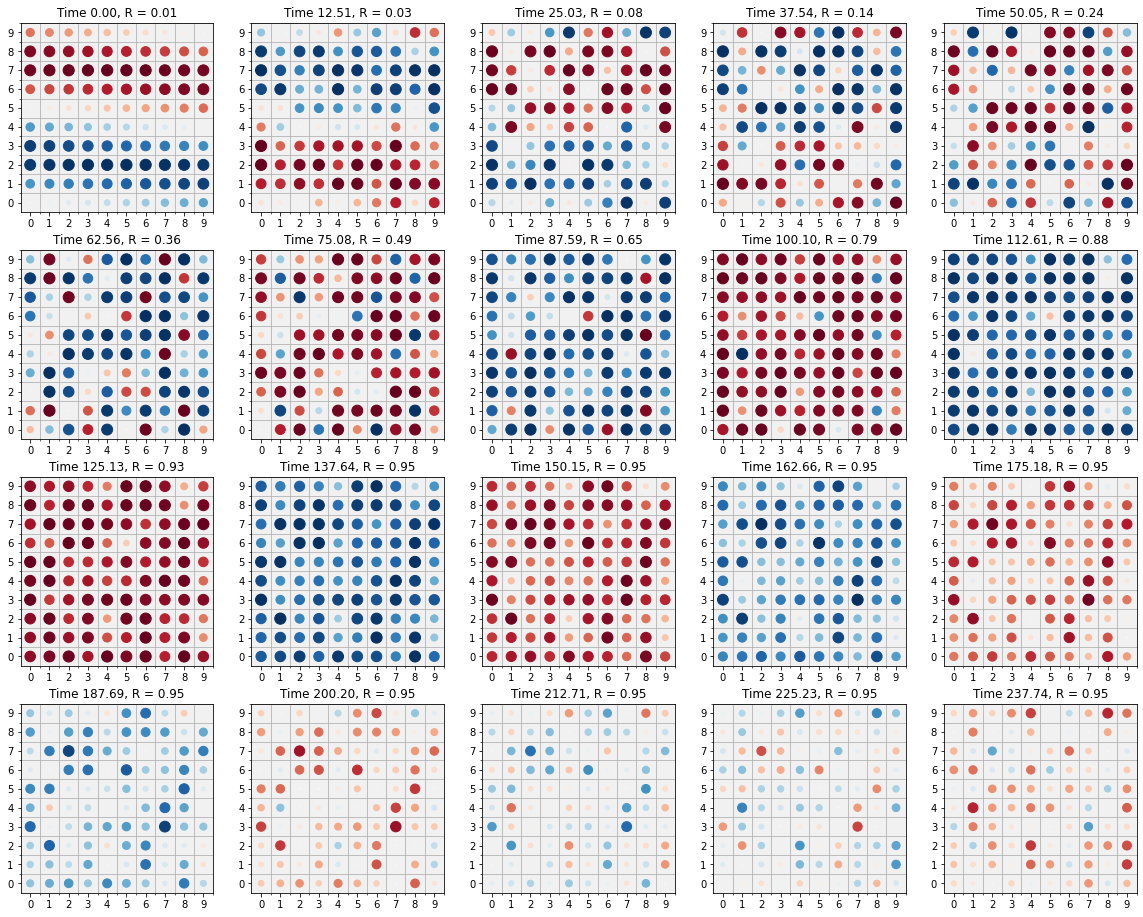

In [10]:
fig, axs = plt.subplots(4,5,figsize=(20,16))
axs = axs.flatten()

i_show = np.arange(0,nsteps,int(nsteps/20))

for ax, i in zip(axs, i_show):
    datagrid = np.sin(X[i,:])
    heatmap(datagrid, marker='.',ax=ax)
    ax.set_title("Time {0:.2f}, R = {1:.2f}".format(tspan[i], abs(order(X[i,:]))))

plt.show()

#### Question 3:  
Generate a random adjacency matrix where $\mathbf{A}_{ij} = 1$ with a probability $p$, where a ‘success’ will generate $\mathbf{A}=\mathbf{1}$ and $\mathbf{A}=\mathbf{0}$ otherwise.

Plot the final state for the different $p$ (both bigger and smaller than the critical probability) using again the function _heatmap_.

It took  65.11580896377563  s.


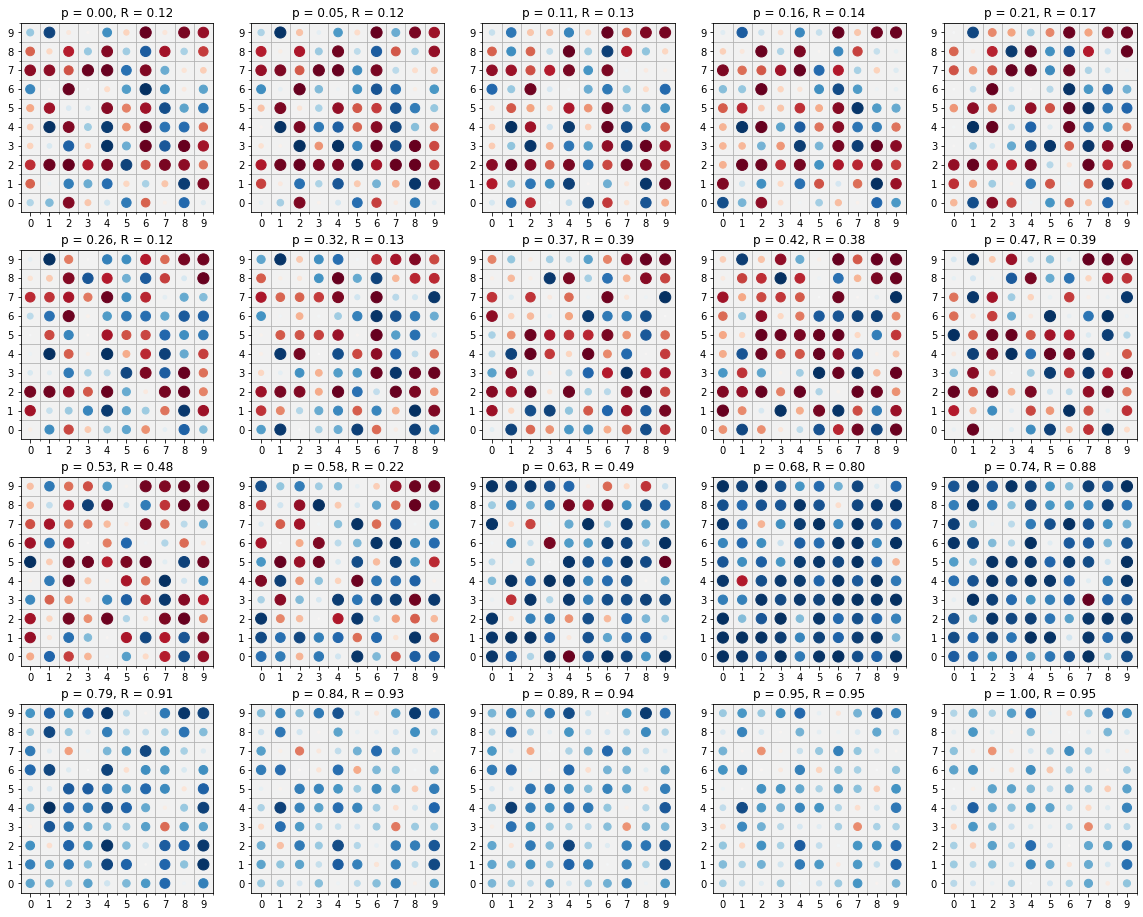

In [11]:
start = time()

fig, axs = plt.subplots(4,5,figsize=(20,16))
axs = axs.flatten()

P = np.linspace(0,1,20)
R = np.zeros(shape=(len(P),))
M = 5

for k, p in enumerate(P):
    
    A = A_alltoall(N,p)
    
    K = 0.001
    
    #simulate neurons
    X = odeint(model, l_x0, tspan, args=(l_f, K, A))
    X = np.reshape(X, (X.shape[0], int(N**0.5),int(N**0.5)))
    datagrid = np.sin(X[-1,:])
    heatmap(datagrid, marker='.',ax=axs[k])
    
    r = 0
    for l in np.arange(M):
        r += abs(order(X[-(l+1),:]))
    R[k] = r/M
    
    axs[k].set_title("p = {0:.2f}, R = {1:.2f}".format(p, R[k]))

end=time()

print("It took ", end-start, " s.")

#### Question 4:  
Plot the function $R(p)$ (with $R$ defined at the beginning of this series).
Find the critical probability: the probability of the neuron connections when the system becomes syncronized $\sim R\ge 0.5$. Use at least $10$ different values of $p$ for the plot.

**Hint:** to have a "reliable" estimate of $R$, you could average it on some time (at the end of the simulation).

Which is the critical value of $p$? (Note that this in general will depend on the $\sigma$ you chose to generate your initial conditions).

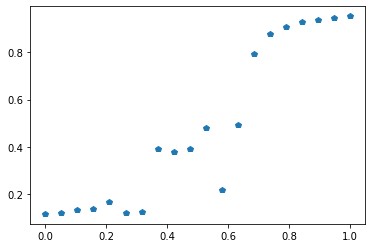

In [12]:
plt.plot(P,R,'p')